In [243]:
import geopandas as gpd
import plotly.express as px
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

In [3]:
sns.set_theme(style="whitegrid")

In [6]:
data_dir = Path('/Users/suzinyou/Dropbox/가천대 서울연구원 프로젝트/10. 데이터산출물')

# 1. 서울

In [222]:
ds = pd.read_csv(data_dir / '01_descriptive_statistics' / 'seoul_desc_stat_yearonly.csv')

In [7]:
ds.head()

,STD_YYYY,var,count,nmiss,mean,max,min,std
0,2002,inc_wage,0,11447247,NaN,NaN,NaN,NaN
1,2003,inc_wage,2715040,8309784,2.408006e+07,4.713851e+10,1.0,4.685934e+07
2,2004,inc_wage,2467284,7921970,2.592367e+07,5.704411e+10,1.0,6.124182e+07
3,2005,inc_wage,2514863,7883449,2.756987e+07,6.014819e+10,1.0,6.819875e+07
4,2006,inc_wage,2623418,7786102,2.889745e+07,8.000351e+10,1.0,7.445346e+07


In [8]:
ds.loc[:, 'missing_frac'] = ds['nmiss'] / (ds['count'] + ds['nmiss'])

## 변수별 fraction of missing values

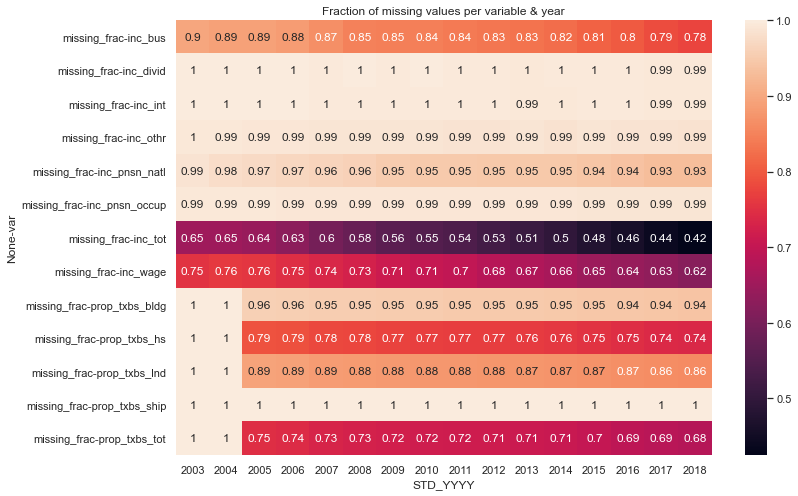

In [9]:
missing_matrix = ds.loc[
    ds['STD_YYYY'] > 2002, 
    ['var', 'STD_YYYY', 'missing_frac']
].pivot(index='STD_YYYY', columns='var').T
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Fraction of missing values per variable & year")
sns.heatmap(missing_matrix, annot=True, ax=ax);

## 평균 소득 및 과세표준 추이

In [239]:
stat2ko = {
'mean': '평균',
    'max': '최대', 'min': '최소', 'std': '표준편차', 'count':'인원'
}
var2ko = {'inc_tot': '총소득', 'inc_wage':'근로소득', 'inc_bus':'사업소득', 'prop_txbs_tot':'총과세표준',}
def plot_lines(variables, y, title):
    fig = px.line(ds[ds['var'].apply(lambda x: x in variables)], x='STD_YYYY', y=y, color='var')
    fig.update_layout(
        margin={"r":16,"t":72,"l":16,"b":16},
        title=f"서울시 {stat2ko[y]} {title} 추이",)
    fig.show()

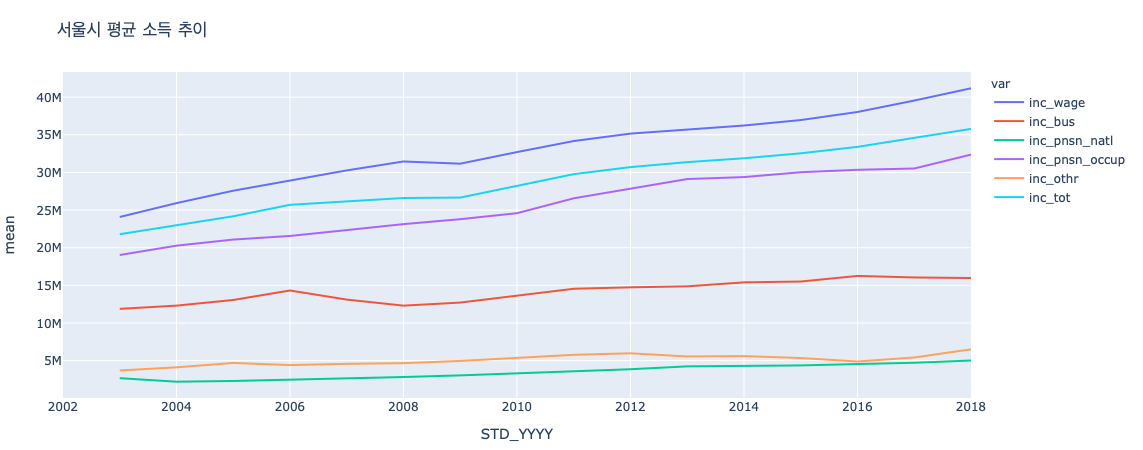

In [240]:
plot_lines(['inc_tot', 'inc_wage', 'inc_bus', 'inc_pnsn_natl', 'inc_pnsn_occup', 'inc_othr'], y='mean', title='소득')

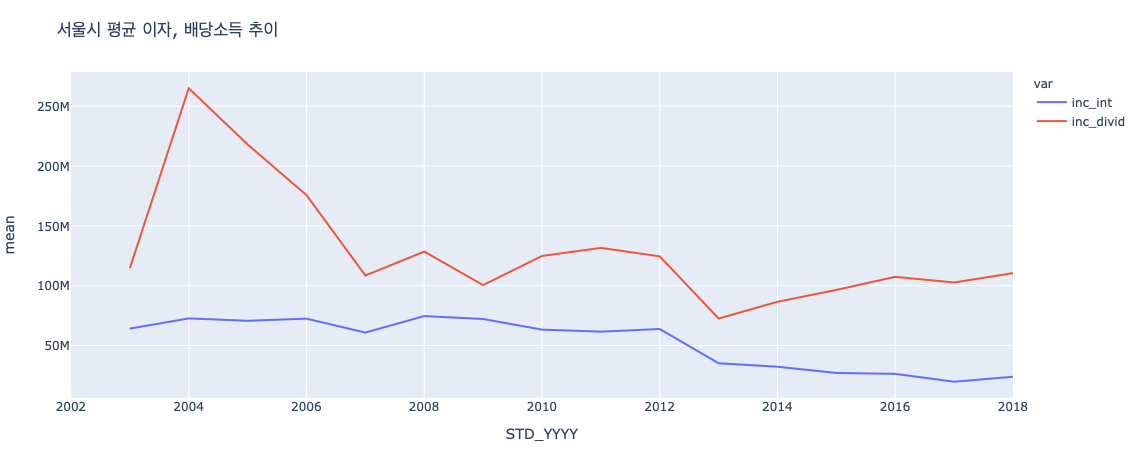

In [241]:
plot_lines(['inc_int', 'inc_divid'], y='mean', title='이자, 배당소득',)

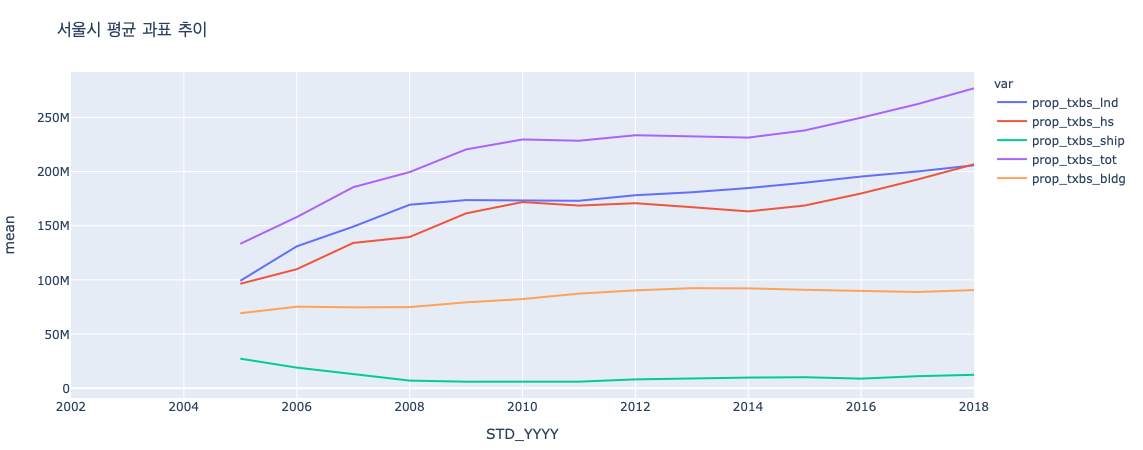

In [242]:
plot_lines([v for v in ds['var'].unique() if v.startswith('prop')], y='mean', title='과표',)

# 2. 서울시 25개 구별 평균 소득 추이

In [82]:
mapdir = Path('/Users/suzinyou/workspace/inequality/data/external/maps')

gdf = gpd.read_file('/Users/suzinyou/Downloads/SIG/SIG.shp', encoding='utf-8')
gdf = gdf[gdf.SIG_CD.apply(lambda x: x.startswith('11'))] # 서울만 필터
gdf = gdf.to_crs(epsg=4326) # convert to GPS coordinates
gdf.to_file('geojsfile.json', driver = 'GeoJSON')
with open('geojsfile.json') as geofile:
    geojson_data = json.load(geofile)

In [21]:
sigungudf = pd.read_csv(mapdir / 'SIG.csv')

In [25]:
sigungudf.head()

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,GU_CD
0,11110,Jongno-gu,종로구,110
1,11140,Jung-gu,중구,140
2,11170,Yongsan-gu,용산구,170
3,11200,Seongdong-gu,성동구,200
4,11215,Gwangjin-gu,광진구,215


In [142]:
sigungudf['SIG_CD'] = sigungudf['SIG_CD'].astype(str)

In [11]:
ds = pd.read_csv(data_dir / '01_descriptive_statistics' / 'seoul_desc_stat_sidosigungu.csv')
ds.loc[:, 'SIG_CD'] = ds.apply(lambda row: str(row.sido * 1000 + row.sigungu), axis=1)
ds = ds.merge(sigungudf[['SIG_CD', 'SIG_KOR_NM', 'SIG_ENG_NM']], how='left')

In [185]:
ds.columns

Index(['STD_YYYY', 'sido', 'sigungu', 'var', 'count', 'nmiss', 'mean', 'max',
       'min', 'std', 'SIG_CD', 'SIG_KOR_NM', 'SIG_ENG_NM'],
      dtype='object')

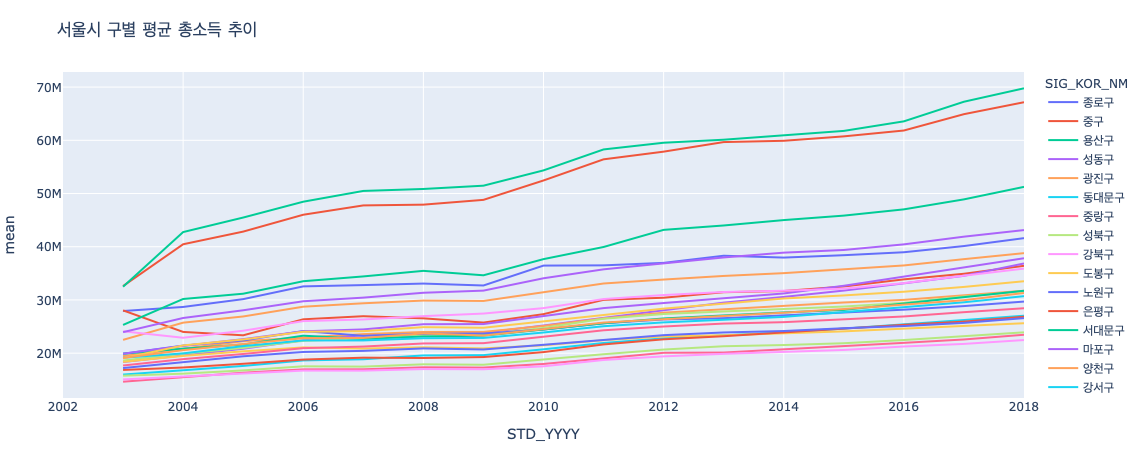

In [219]:
fig = px.line(ds[ds['var']=='inc_tot'], x='STD_YYYY', y='mean', color='SIG_KOR_NM')
fig.update_layout(
    margin={"r":16,"t":72,"l":16,"b":16},
    title='서울시 구별 평균 총소득 추이',)
fig.show()

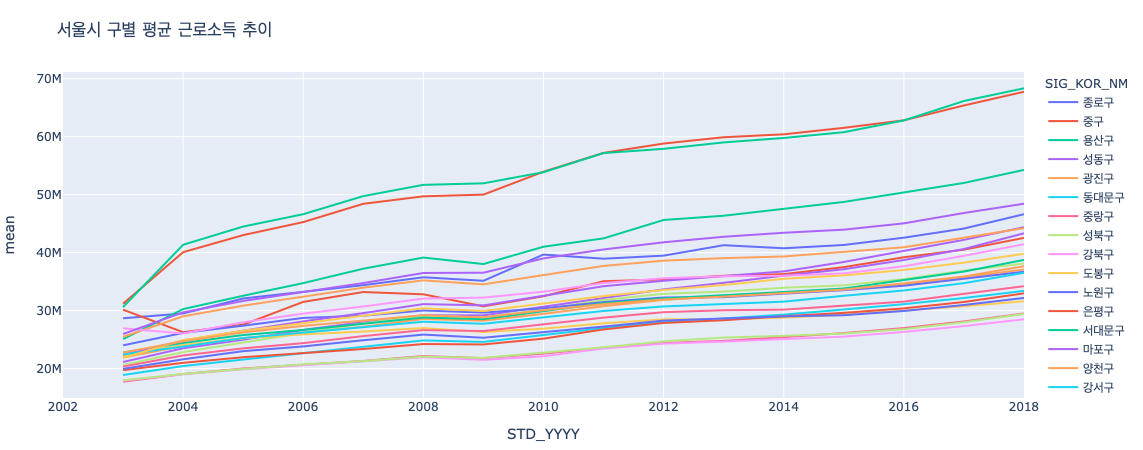

In [220]:
fig = px.line(ds[ds['var']=='inc_wage'], x='STD_YYYY', y='mean', color='SIG_KOR_NM')
fig.update_layout(
    margin={"r":16,"t":72,"l":16,"b":16},
    title='서울시 구별 평균 근로소득 추이',)
fig.show()

# 총 소득 2018

In [210]:
def show_seoul(year, var):
    df_slice = ds[(ds.STD_YYYY == year) & (ds['var'] == var)]
    fig = px.choropleth_mapbox(df_slice, 
                               geojson=geojson_data, 
                               locations='SIG_KOR_NM', 
                               color='mean',
                               color_continuous_scale="Viridis",
                               mapbox_style="carto-positron",
                               zoom=9.6, center = {"lat": 37.55, "lon": 126.98},
                               opacity=0.7,
                               labels={'mean':f'평균 {var2ko[var]}', 'SIG_KOR_NM':'행정구'},
                               featureidkey='properties.SIG_KOR_NM'
                              )
    fig.update_layout(margin={"r":0,"t":72,"l":0,"b":0},
                     title=f"{year}년 서울시 구별 {var2ko[var]}")
    # TODO: dropdown menu
    fig.show()

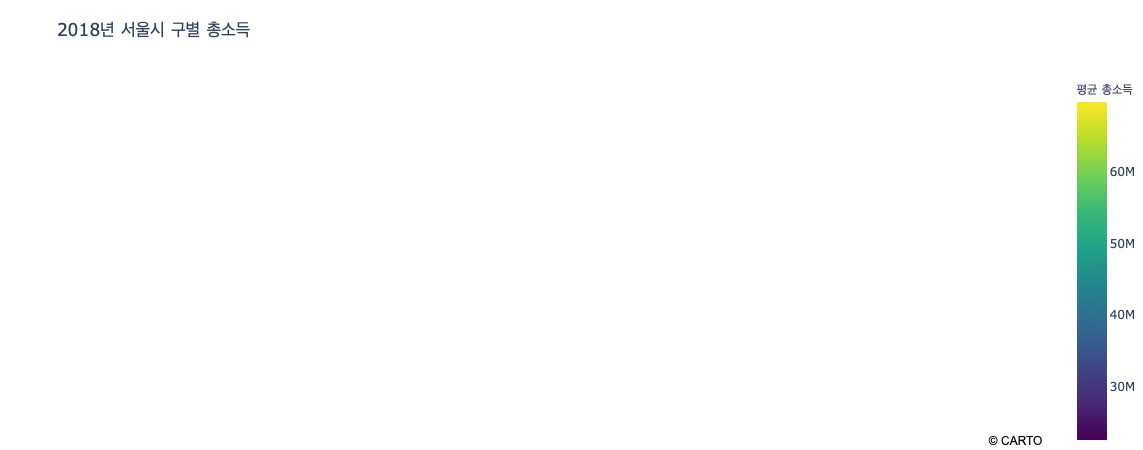

In [211]:
show_seoul(2018, 'inc_tot')

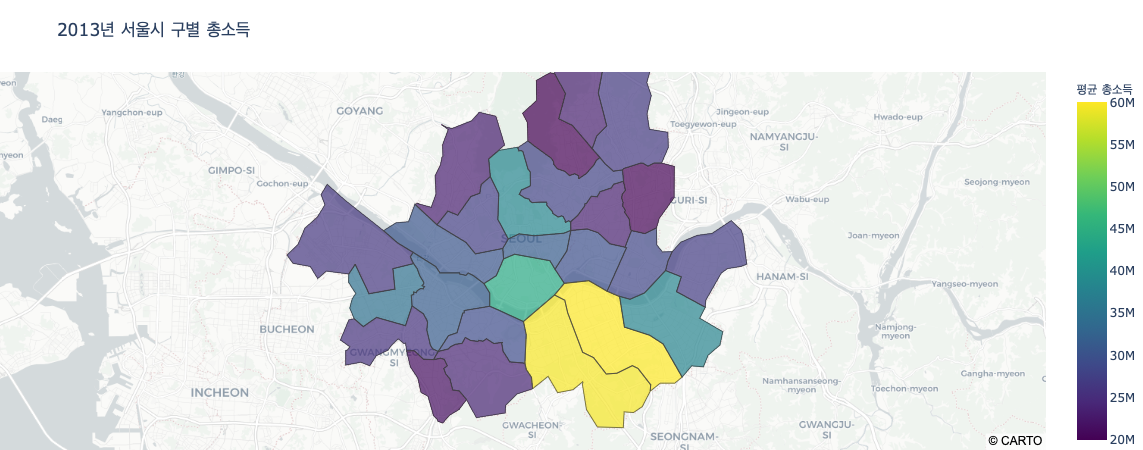

In [212]:
show_seoul(2013, 'inc_tot')

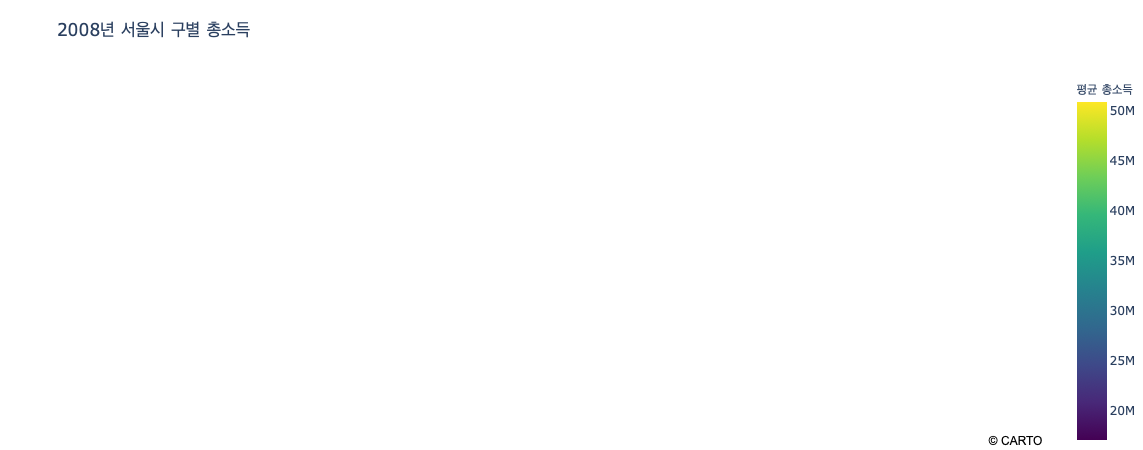

In [213]:
show_seoul(2008, 'inc_tot')

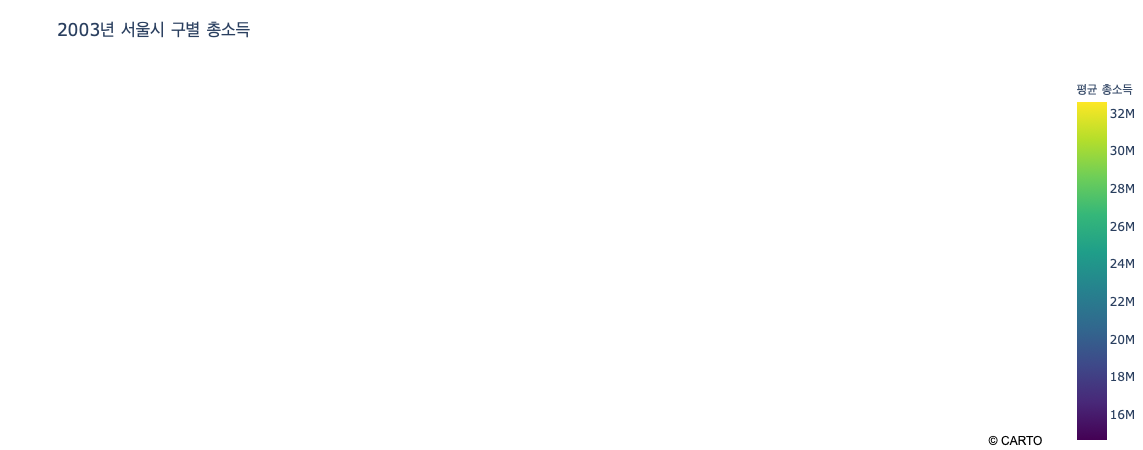

In [214]:
show_seoul(2003, 'inc_tot')